# House Prices - Data Preprocessing

Based on earlier EDA, we know:

* There are a lot of missing values in the data
* There are also duplicative (highly-correlated) features that add no extra value
* `Id` can probably be safely deleted as it is simply a auto-incrementing label for each observation
* The target variable, `SalePrice`, is right skewed and will need to be log-transformed

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, LassoCV

# Prevent Pandas from truncating displayed dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]

**Load the Data**

In [187]:
train = pd.read_csv("assets/train.csv")
test = pd.read_csv("assets/test.csv")
submission = pd.read_csv("assets/sample_submission.csv")

# Prepare our base training data
X = train.copy()
y = X.pop("SalePrice")

# Drop the unnecessary Id column
X = X.drop(columns="Id")
test = test.drop(columns="Id")

In [188]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


**Create Helper Functions**

In [189]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

**Pre-Processing**

In [190]:
numeric_features = X.select_dtypes(include=[np.number]).columns
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [191]:
categorical_features = train.select_dtypes(include=[np.object]).columns
categorical_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [192]:
train[categorical_features].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


**Deal with Missing Values**

In [193]:
all_data = pd.concat([X, test])
nulls = all_data.isnull().sum()[all_data.isnull().sum() > 0].sort_values(ascending=False).to_frame().rename(columns={0: "MissingVals"})
nulls["MissingValsPct"] = nulls["MissingVals"] / len(all_data)
nulls

,MissingVals,MissingValsPct
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471


In [194]:
all_data[all_data["GarageYrBlt"].isnull()].head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
39,90,RL,65.0,6040,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,N,FuseP,1152,0,0,1152,0.0,0.0,2,0,2,2,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand
48,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,736.0,736.0,GasA,Gd,Y,SBrkr,736,716,0,1452,0.0,0.0,2,0,2,3,TA,8,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,102,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial
78,90,RL,72.0,10778,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1768.0,1768.0,GasA,TA,N,SBrkr,1768,0,0,1768,0.0,0.0,2,0,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
88,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,1013.0,1013.0,GasA,TA,N,SBrkr,1013,0,513,1526,0.0,0.0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml
89,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588.0,Unf,0.0,402.0,990.0,GasA,Ex,Y,SBrkr,990,0,0,990,1.0,0.0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal


In [195]:
# Very helpful: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

for df in [X, test]:
    ## EASIER TO HANDLE:
    
    # PoolQC -> data description says NA = No Pool
    df["PoolQC"].fillna(value="None", inplace=True)
    # MiscFeature -> data description says NA = None
    df["MiscFeature"].fillna(value="None", inplace=True)
    # Alley -> data description says NA = No alley access
    df["Alley"].fillna(value="None", inplace=True)
    # Fence -> data description says NA = No fence
    df["Fence"].fillna(value="None", inplace=True)
    # FireplaceQu -> data description says NA = No fireplace
    df["FireplaceQu"].fillna(value="None", inplace=True)
    # Garage features -> data description says NA = No garage
    df["GarageType"].fillna(value="None", inplace=True)
    df["GarageFinish"].fillna(value="None", inplace=True)
    df["GarageQual"].fillna(value="None", inplace=True)
    df["GarageCond"].fillna(value="None", inplace=True)
    df["GarageArea"].fillna(value=0, inplace=True)
    df["GarageCars"].fillna(value=0, inplace=True)
    # Basement features -> data description says NA = No garage
    df["BsmtCond"].fillna(value="None", inplace=True)
    df["BsmtExposure"].fillna(value="None", inplace=True)
    df["BsmtQual"].fillna(value="None", inplace=True)
    df["BsmtFinType1"].fillna(value="None", inplace=True)
    df["BsmtFinSF1"].fillna(value=0, inplace=True)
    df["BsmtFinType2"].fillna(value="None", inplace=True)
    df["BsmtFinSF2"].fillna(value=0, inplace=True)
    df["TotalBsmtSF"].fillna(value=0, inplace=True)
    df["BsmtUnfSF"].fillna(value=0, inplace=True)
    df["BsmtFullBath"].fillna(value=0, inplace=True)
    df["BsmtHalfBath"].fillna(value=0, inplace=True)
    # Functional -> data description says assume typical
    df["Functional"].fillna(value="Typ", inplace=True)
    
    ## LESS CLEAR:
    
    # LotFrontage -> assume median
    df["LotFrontage"].fillna(value=df["LotFrontage"].median(), inplace=True)
    # GarageYrBlt -> assume equal to YearBuilt
    df["GarageYrBlt"].fillna(value=df["YearBuilt"], inplace=True)
    # MasVnrType -> NA most likely means no masonry veneer
    df["MasVnrType"].fillna(value="None", inplace=True)
    df["MasVnrArea"].fillna(value=0, inplace=True)
    # Utilities -> assume the mode
    df["Utilities"].fillna(value=df["Utilities"].mode()[0], inplace=True)
    # SaleType -> assume the mode
    df["SaleType"].fillna(value=df["SaleType"].mode()[0], inplace=True)
    # KitchenQual -> assume the mode
    df["KitchenQual"].fillna(value=df["KitchenQual"].mode()[0], inplace=True)
    # Electrical -> assume the mode
    df["Electrical"].fillna(value=df["Electrical"].mode()[0], inplace=True)    
    # MSZoning -> assume the mode
    df["MSZoning"].fillna(value=df["MSZoning"].mode()[0], inplace=True)  
    # Exterior1st -> assume the mode
    df["Exterior1st"].fillna(value=df["Exterior1st"].mode()[0], inplace=True)  
    # Exterior2nd -> assume the mode
    df["Exterior2nd"].fillna(value=df["Exterior2nd"].mode()[0], inplace=True)

When filling NAs, it can be helpful to plot the mean and the median alongside the feature's distribution. This can help illustrate when the mean is impacted by outliers.

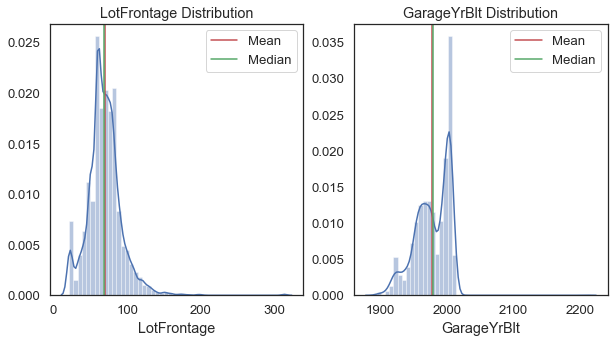

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(all_data["LotFrontage"].dropna(), ax=ax[0])
ax[0].axvline(x=all_data["LotFrontage"].mean(), ymin=0, ymax=1, color='r', label="Mean")
ax[0].axvline(x=all_data["LotFrontage"].median(), ymin=0, ymax=1, color='g', label="Median")
ax[0].legend()
ax[0].set_title("LotFrontage Distribution")


sns.distplot(all_data["GarageYrBlt"].dropna(), ax=ax[1])
ax[1].axvline(x=all_data["GarageYrBlt"].mean(), ymin=0, ymax=1, color='r', label="Mean")
ax[1].axvline(x=all_data["GarageYrBlt"].median(), ymin=0, ymax=1, color='g', label="Median")
ax[1].legend()
ax[1].set_title("GarageYrBlt Distribution")

plt.show()

In [197]:
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

**Convert Select Numeric Features to Categorical Features**

In [208]:
# By making these substitutions, the columns are automatically cast to datatype object
all_data = all_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

**Remove/Fix Outliers**

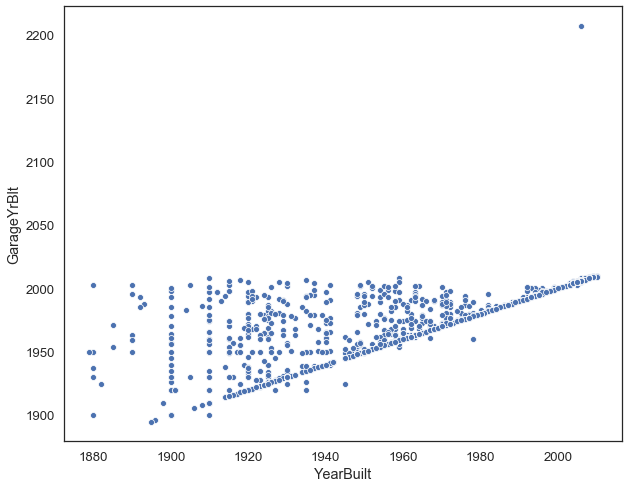

In [202]:
sns.scatterplot(x=all_data["YearBuilt"], y=all_data["GarageYrBlt"])
plt.show()

In [203]:
# Assume that 2207 was meant to be 2007
all_data.loc[all_data["GarageYrBlt"] == 2207] = 2007

**Log-Transform Skewed Numeric Variables**

In [204]:
y = np.log1p(y) # SalePrice

for df in [y, X[numeric_features], test[numeric_features]]:
    df = np.log1p(df)

**Baseline Model using Numeric Only Data**

Best RMSE for Ridge Regression = 0.1547 for alpha = 28.461805555555557


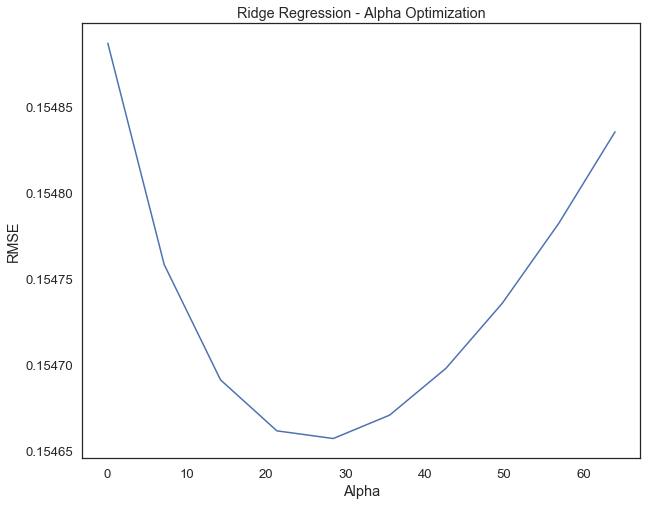

Best RMSE for Lasso Regression = 0.1671 for alpha = 0.03125


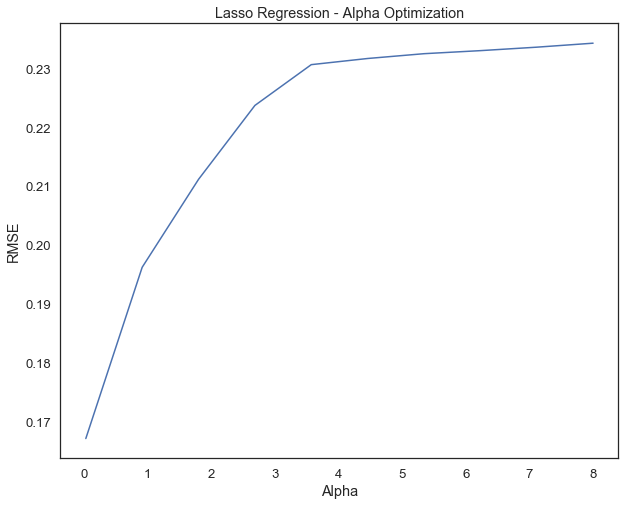

In [205]:
X_numeric = X[numeric_features]
X_numeric = X_numeric.fillna(X_numeric.mean())

model_ridge = Ridge()

alphas = np.linspace(2**(-5), 2**6, num=10)
cv_ridge = [rmse_cv(Ridge(alpha=alpha), X_numeric, y).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
sns.lineplot(x=alphas, y=cv_ridge)
plt.title("Ridge Regression - Alpha Optimization")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

print("Best RMSE for Ridge Regression = {:.4f} for alpha = {}".format(cv_ridge.min(), alphas[np.argmin(cv_ridge.values)]))
plt.show()

alphas = np.linspace(2**(-5), 2**3, num=10)
cv_lasso = [rmse_cv(Lasso(alpha=alpha), X_numeric, y).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index=alphas)
sns.lineplot(x=alphas, y=cv_lasso)
plt.title("Lasso Regression - Alpha Optimization")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

print("Best RMSE for Lasso Regression = {:.4f} for alpha = {}".format(cv_lasso.min(), alphas[np.argmin(cv_lasso.values)]))
plt.show()

**LabelEncode the Ordinal Features**

Using the data description file, we can determine which categorical columns refer to ordinal characteristics, or those with an implied order.

In [206]:
ordinal_cols = ["ExterQual", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "LandSlope", "ExterCond", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC"]
nominal_cols = list(set(categorical_features.columns) - set(ordinal_cols))

AttributeError: 'Index' object has no attribute 'columns'

In [ ]:
label_encoder = LabelEncoder()
train[ordinal_cols] = train[ordinal_cols].apply(LabelEncoder().fit_transform)

**One-Hot Encode the Nominal Features**

In [ ]:
# https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding
train_dummies = pd.get_dummies(X[nominal_cols])
test_dummies = pd.get_dummies(test[nominal_cols])
train, test = train_dummies.align(test_dummies, join="left", axis=1)